In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, cv, Pool
import warnings
warnings.filterwarnings("ignore")

## **Загрузка данных**

In [4]:
train_df = pd.read_parquet("data/train_data.pqt")
test_df = pd.read_parquet("data/test_data.pqt")

In [5]:
train_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}


In [6]:
test_df.head(3)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,None


## **Предобработка данных**

Определение списка категориальных признаков:

In [7]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

Выделение числовых признаков:

In [8]:
non_cat_cols = train_df.drop(cat_cols, axis=1)

### **Преобразование категориальных признаков**:
   - Приведение значений в категориальных признаках к типу данных "str" (строка) как в обучающем наборе данных train_df, так и в тестовом наборе данных test_df.
   - Для обучения модели, в дальнейшем категориальные признаки были преобразованы в тип "category" для корректной работы модели CatBoost.



In [9]:
train_df[cat_cols] = train_df[cat_cols].astype("str")
test_df[cat_cols] = test_df[cat_cols].astype("str")

### **Создаем выборки для валидации и обучения**

 **Добавление данных за предыдущие месяцы**:
   - Мы прогнозируем переход в новый кластер только для 6 месяца, но в тествой выборке также присутсвует информация о двух предшествующих месяцах.
   - Возможно, целесообразно использовать эту информацию при построении прогноза
   - Для проверки полезности подобного хода, были созданы дополнительные столбцы, содержащие информацию за предыдущие два месяца(1 и 2).
   - В обучающей выборке эти данные были объединены с данными за последний месяц
   - Модель была обучена на новой выборке
   - Оказалось, что многие из добавленных столбцов имели достаточно высокий feature_importance
   - Также добавленные столбцы позволили снизить loss при обучении модели
   - Был построен прогноз на тестовой выборке
   - weighted roc_auc повысился вследствие предпинятых действий

Оставляем только 3 месяц, данные за 1 и 2 добаляем как новые столбцы

In [10]:
# Фильтрация данных, оставляем только записи за последний месяц
last_month_df = train_df[train_df['date'] == 'month_3']

# Создание DataFrame для данных за предыдущие два месяца
prev_month_2_df = train_df[train_df['date'] == 'month_2'].set_index('id')
prev_month_1_df = train_df[train_df['date'] == 'month_1'].set_index('id')
prev_month_2_df[cat_cols] = prev_month_2_df[cat_cols].astype("category")
prev_month_1_df[cat_cols] = prev_month_1_df[cat_cols].astype("category")

# Переименование столбцов, чтобы избежать конфликтов имен
prev_month_2_df.columns = [f'{col}_prev_month_2' for col in prev_month_2_df.columns]
prev_month_1_df.columns = [f'{col}_prev_month_1' for col in prev_month_1_df.columns]

# Объединение данных за предыдущие месяцы
prev_months_combined = prev_month_2_df.join(prev_month_1_df, how='outer')

# Объединение данных за последний месяц с данными за предыдущие месяцы
final_df = last_month_df.set_index('id').join(prev_months_combined, how='left')

final_df

,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,...,cnt_cred_g_oper_3m_prev_month_1,cnt_days_cred_g_oper_3m_prev_month_1,sum_deb_h_oper_3m_prev_month_1,cnt_deb_h_oper_3m_prev_month_1,cnt_days_deb_h_oper_3m_prev_month_1,sum_cred_h_oper_3m_prev_month_1,cnt_cred_h_oper_3m_prev_month_1,cnt_days_cred_h_oper_3m_prev_month_1,start_cluster_prev_month_1,end_cluster_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,month_3,-0.090605,-0.114275,-0.114119,-0.089937,channel_code_2,city_14,city_type_0,None,0.324343,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
2,month_3,-0.148737,-0.187003,-0.112416,-0.148249,channel_code_12,city_613,city_type_306,None,-0.256297,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.178674,0.252657,0.440474,{α},{α}
3,month_3,-0.156522,-0.204718,-0.125759,-0.156058,channel_code_14,city_21,city_type_0,index_city_code_46,-1.185321,...,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,{α},{α}
4,month_3,-0.141798,-0.170262,-0.125672,-0.141289,channel_code_8,city_21,city_type_0,None,-1.417577,...,0.957443,0.672129,-0.078233,0.558209,0.707687,-0.178408,0.252946,0.440474,{α},{α}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,month_3,-0.039281,-0.053694,-0.044193,-0.038454,channel_code_9,city_20,city_type_0,index_city_code_28,1.601751,...,0.944497,0.384773,-0.161095,0.547319,0.429909,-0.201123,0.250924,0.374540,"{α, η}",{other}
199996,month_3,0.293117,0.189316,0.857952,0.294974,channel_code_14,city_3595,city_type_2778,index_city_code_48,-0.953065,...,0.944889,0.396267,-0.151699,0.553767,0.574354,-0.201123,0.250924,0.374540,"{α, γ}","{α, γ}"
199997,month_3,0.032941,0.140726,-0.125362,0.033992,channel_code_8,city_0,city_type_0,index_city_code_58,1.485623,...,0.944889,0.396267,1.185234,0.571535,0.918798,0.955885,0.264788,0.693221,{other},{other}


Преобразование столбцов с информацией о кластерах в категориальный тип данных

In [11]:
# Функция для добавления новых слов в названия столбцов
def add_word(cols, suffix):
    return [col + suffix for col in cols]

# Добавление"_prev_month_2" и "_prev_month_1"
new_cat_cols = add_word(cat_cols, "_prev_month_2") + add_word(cat_cols, "_prev_month_1")
cat_cols += new_cat_cols

In [12]:
final_df[cat_cols] = final_df[cat_cols].astype("category")

 ### **Удаление незначимых признаков**:
  - Изначальная спецификация была построена на всех признаках.
   - Был проведен анализ нулевой важности признаков и выявлены незначимые признаки(feature_importance=0).
   - Незначимые признаки были удалены из данных.
   - Упрощение модели упростило оптимизацию параметров и дало прирост в точности и производительности.

In [13]:
zero_importance = ['city_type',
 'cnt_cred_d_oper_1m',
 'sum_deb_d_oper_3m',
 'cnt_deb_d_oper_3m',
 'sum_cred_d_oper_3m',
 'cnt_days_cred_f_oper_3m',
 'cnt_days_cred_g_oper_3m',
 'cnt_cred_h_oper_3m',
 'city_prev_month_2',
 'city_type_prev_month_2',
 'ogrn_days_end_quarter_prev_month_2',
 'sum_of_paym_2m_prev_month_2',
 'cnt_b_oper_1m_prev_month_2',
 'cnt_days_cred_f_oper_1m_prev_month_2',
 'cnt_deb_g_oper_1m_prev_month_2',
 'cnt_days_cred_g_oper_1m_prev_month_2',
 'cnt_deb_h_oper_1m_prev_month_2',
 'cnt_cred_h_oper_1m_prev_month_2',
 'cnt_days_cred_h_oper_1m_prev_month_2',
 'sum_b_oper_3m_prev_month_2',
 'sum_cred_d_oper_3m_prev_month_2',
 'cnt_cred_d_oper_3m_prev_month_2',
 'sum_cred_f_oper_3m_prev_month_2',
 'cnt_days_cred_f_oper_3m_prev_month_2',
 'cnt_deb_g_oper_3m_prev_month_2',
 'cnt_cred_g_oper_3m_prev_month_2',
 'city_type_prev_month_1',
 'sum_a_oper_1m_prev_month_1',
 'cnt_b_oper_1m_prev_month_1',
 'sum_cred_d_oper_1m_prev_month_1',
 'cnt_cred_e_oper_1m_prev_month_1',
 'cnt_days_deb_f_oper_1m_prev_month_1',
 'cnt_days_cred_f_oper_1m_prev_month_1',
 'cnt_deb_g_oper_1m_prev_month_1',
 'cnt_days_deb_g_oper_1m_prev_month_1',
 'sum_cred_g_oper_1m_prev_month_1',
 'cnt_days_cred_h_oper_1m_prev_month_1',
 'cnt_deb_d_oper_3m_prev_month_1',
 'sum_cred_d_oper_3m_prev_month_1',
 'cnt_cred_f_oper_3m_prev_month_1',                  
]

In [14]:
cat_cols_to_remove = (list(set(zero_importance) & set(cat_cols)))
cat_cols_to_remove

['city_type',
 'city_type_prev_month_2',
 'city_type_prev_month_1',
 'city_prev_month_2']

In [15]:
X = final_df.drop(["date", "end_cluster",'date_prev_month_1','date_prev_month_2','end_cluster_prev_month_1','end_cluster_prev_month_2'], axis=1)
X = X.drop(zero_importance, axis=1)
cat_cols = list(set(cat_cols).difference(cat_cols_to_remove))
y = final_df["end_cluster"]

## **Обучение модели**

В качестве базовой модели была выбрана Catboost и обучена на значимых признаках.

Зададим функцию для взвешенной метрики roc auc, которая вычисляет взвешенную площадь под ROC-кривой для многоклассовой классификации.

In [26]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr")#, average=None)
    return sum(weights * classes_roc_auc)

 Загрузка весов кластеров из файла Excel и создание словаря weights_dict для использования в функции weighted_roc_auc

In [16]:
cluster_weights = pd.read_excel("data/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

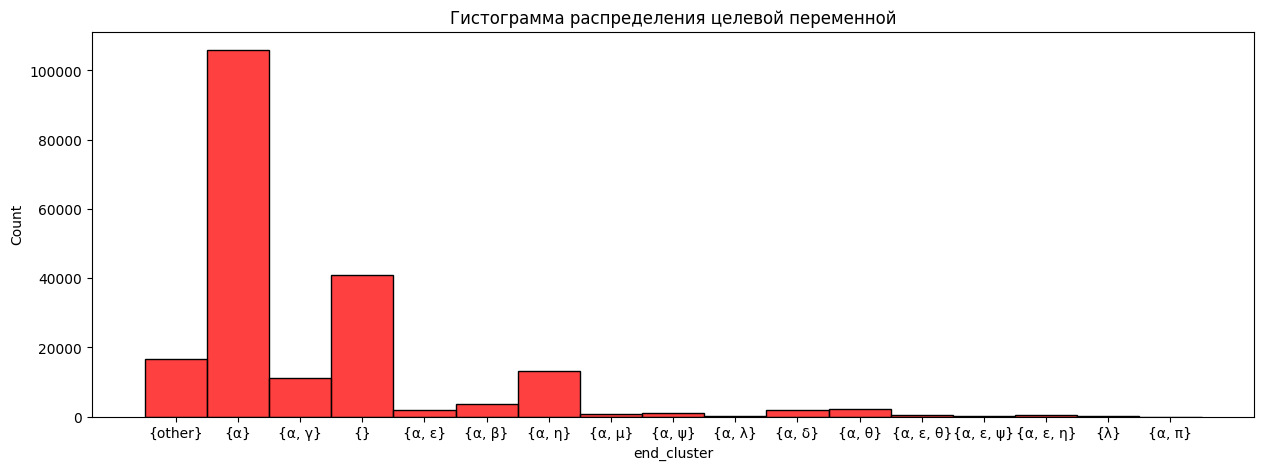

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(y, ax=ax, color='r')
plt.title('Гистограмма распределения целевой переменной')
plt.show()

Анализ гистограммы позволяет сделать вывод о преобладании класса alpha и класса {} в данных, что связано с распределением целевой переменной y. На гистограмме видно, что эти классы встречаются чаще других, что может привести к более высокому количеству ошибок при прогнозировании. Распределение классов не является равномерным, и класс {} и alpha можно выделить как мажоритарные. Для улучшения качества модели можно добавить в распределение больше наблюдений о минорных классах.  Для решения этой проблемы мы пробовали различные методы балансировки классов, такие как oversampling (увеличение числа примеров меньшего класса), что не привело к желаемым результатам.


После попыток исправить дисбаланс классов и подстроить модель к бизнес-задаче с использованием весов, а также при экспериментах с изменением характера распределения или корректировки функции потерь через class_weights, качество модели не улучшилось, а скорее ухудшилось. Даже применение техник over-sampling и under-sampling не привело к желаемым результатам.


**Обучение модели CatBoost на кросс-валидации**

По кросс-валидации мы определяли оптимальные параметры модели, теперь результаты меньше зависят от того, как мы разделим выборку.



In [36]:
cv_dataset = Pool(data=X,
                  label=y,
                  cat_features=cat_cols)

In [40]:
catboost_params = {
    'iterations': 1500,
    'learning_rate': 0.05,
    'depth': 7,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42,
    'early_stopping_rounds': 10,
    'verbose': 20
}

# Создаем CatBoost classifier
model0 = cv(cv_dataset, params=catboost_params, seed=42, fold_count=4, return_models=True)

Training on fold [0/4]
0:	learn: 2.4187802	test: 2.4197662	best: 2.4197662 (0)	total: 104ms	remaining: 2m 36s
20:	learn: 1.1459637	test: 1.1497290	best: 1.1497290 (20)	total: 1.32s	remaining: 1m 33s
40:	learn: 0.9409816	test: 0.9478246	best: 0.9478246 (40)	total: 2.61s	remaining: 1m 33s
60:	learn: 0.8730969	test: 0.8831476	best: 0.8831476 (60)	total: 3.91s	remaining: 1m 32s
80:	learn: 0.8452198	test: 0.8577769	best: 0.8577769 (80)	total: 5.24s	remaining: 1m 31s
100:	learn: 0.8302701	test: 0.8455323	best: 0.8455323 (100)	total: 6.48s	remaining: 1m 29s
120:	learn: 0.8206331	test: 0.8380200	best: 0.8380200 (120)	total: 7.65s	remaining: 1m 27s
140:	learn: 0.8125407	test: 0.8325059	best: 0.8325059 (140)	total: 8.84s	remaining: 1m 25s
160:	learn: 0.8066511	test: 0.8287746	best: 0.8287746 (160)	total: 10s	remaining: 1m 23s
180:	learn: 0.8017201	test: 0.8259930	best: 0.8259930 (180)	total: 11.2s	remaining: 1m 21s
200:	learn: 0.7977042	test: 0.8239062	best: 0.8239062 (200)	total: 12.3s	remainin

Оптимальные параметры:

In [21]:
catboost_params = {
    'iterations': 965,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42
}

In [22]:
model0 = CatBoostClassifier(**catboost_params)

In [43]:
model0.fit(X, y, cat_features=cat_cols, verbose=10)

0:	learn: 2.4239728	total: 76.6ms	remaining: 1m 13s
10:	learn: 1.4333050	total: 629ms	remaining: 54.6s
20:	learn: 1.1559767	total: 1.09s	remaining: 49s
30:	learn: 1.0245511	total: 1.59s	remaining: 47.9s
40:	learn: 0.9530673	total: 2.09s	remaining: 47.1s
50:	learn: 0.9102605	total: 2.57s	remaining: 46.1s
60:	learn: 0.8851954	total: 3.05s	remaining: 45.3s
70:	learn: 0.8687502	total: 3.53s	remaining: 44.4s
80:	learn: 0.8576248	total: 4s	remaining: 43.7s
90:	learn: 0.8493205	total: 4.47s	remaining: 43s
100:	learn: 0.8430422	total: 4.94s	remaining: 42.3s
110:	learn: 0.8380930	total: 5.43s	remaining: 41.8s
120:	learn: 0.8339158	total: 5.88s	remaining: 41s
130:	learn: 0.8301842	total: 6.31s	remaining: 40.2s
140:	learn: 0.8271988	total: 6.75s	remaining: 39.5s
150:	learn: 0.8238973	total: 7.22s	remaining: 38.9s
160:	learn: 0.8214902	total: 7.67s	remaining: 38.3s
170:	learn: 0.8186597	total: 8.14s	remaining: 37.8s
180:	learn: 0.8162808	total: 8.6s	remaining: 37.3s
190:	learn: 0.8143620	total: 9.

In [44]:
# Сохранение модели в файл
model0.save_model('catboost_model_base.bin')

In [24]:
# для быстрой загрузки модели откомментировать
# model0 = CatBoostClassifier(**catboost_params)
# model0 = model0.load_model('models/catboost_model_base.bin')

In [27]:
y_pred_proba_train0 = model0.predict_proba(X)
weighted_roc_auc(y, y_pred_proba_train0, model0.classes_, weights_dict)

0.9503667992781178

**Визуализация матрицы ошибок (Confusion Matrix) для базовой модели CatBoost**

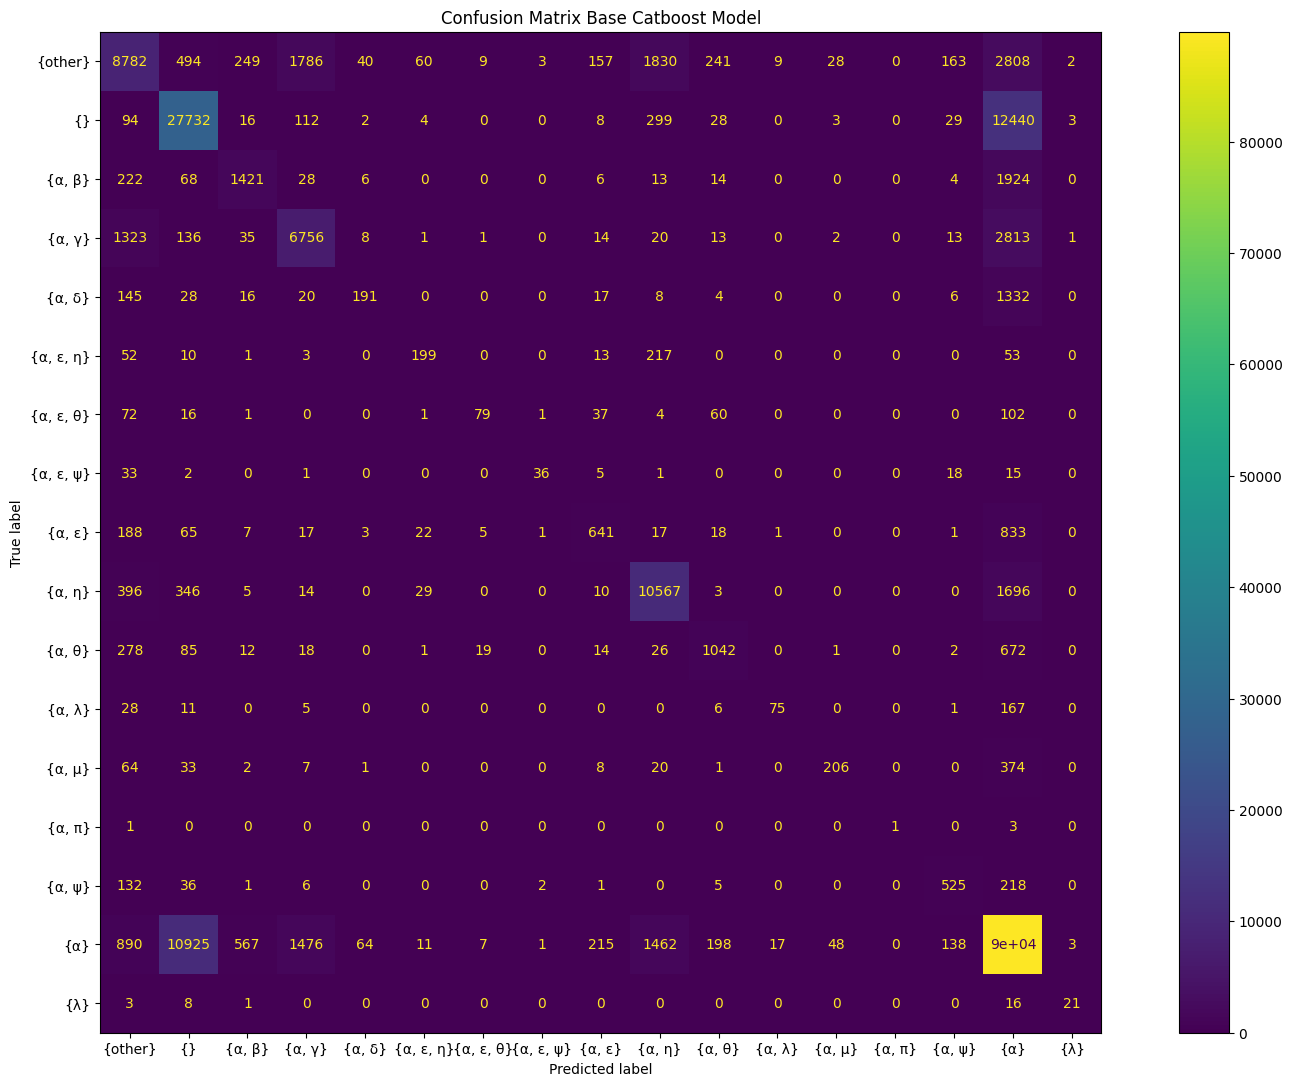

In [48]:
preds0 = model0.predict(X)
figure, ax = plt.subplots(figsize=(20, 13))
ConfusionMatrixDisplay.from_predictions(y, preds0, ax=ax)
plt.title('Confusion Matrix Base Catboost Model')
plt.show()

#### Анализируя confusion matrix, можно сделать вывод о том, что основная часть ошибок сосредоточена в классах alpha и other. Это обусловлено тем, что в этих классов больше всего в данных, что усложняет задачу модели в правильной классификации. Такая неравномерность распределения данных приводит к снижению точности предсказаний. Также, по смыслу other, скорее всего, включает в себя несколько разных совокупностей, что делает классификацию затруднительной из-за неоднородности отличительных признаков класса.


Вычисление и визуализация важности признаков для базовой модели CatBoost

In [50]:
feature_importances = pd.DataFrame(zip(X.columns, model0.feature_importances_))
feature_importances.columns = ['feature name', 'importance']
feature_importances

,feature name,importance
0,balance_amt_avg,1.322332
1,balance_amt_max,1.811282
2,balance_amt_min,2.810553
3,balance_amt_day_avg,1.406283
4,channel_code,1.692176
...,...,...
225,cnt_days_deb_h_oper_3m_prev_month_1,0.279394
226,sum_cred_h_oper_3m_prev_month_1,0.235036
227,cnt_cred_h_oper_3m_prev_month_1,0.138820
228,cnt_days_cred_h_oper_3m_prev_month_1,0.144696


Выделяем подмножество наиболее важных признаков, которые имеют значение важности больше 1.

In [55]:
very_important = feature_importances[feature_importances['importance'] > 1].sort_values(by='importance', ascending=False)

In [56]:
very_important

,feature name,importance
81,start_cluster,11.041196
15,okved,3.788510
6,index_city_code,3.573092
229,start_cluster_prev_month_1,3.525650
5,city,3.043713
2,balance_amt_min,2.810553
156,balance_amt_min_prev_month_1,2.635625
16,segment,2.053670
1,balance_amt_max,1.811282
12,max_founderpres,1.789309


 **Отображение наиболее важных признаков**

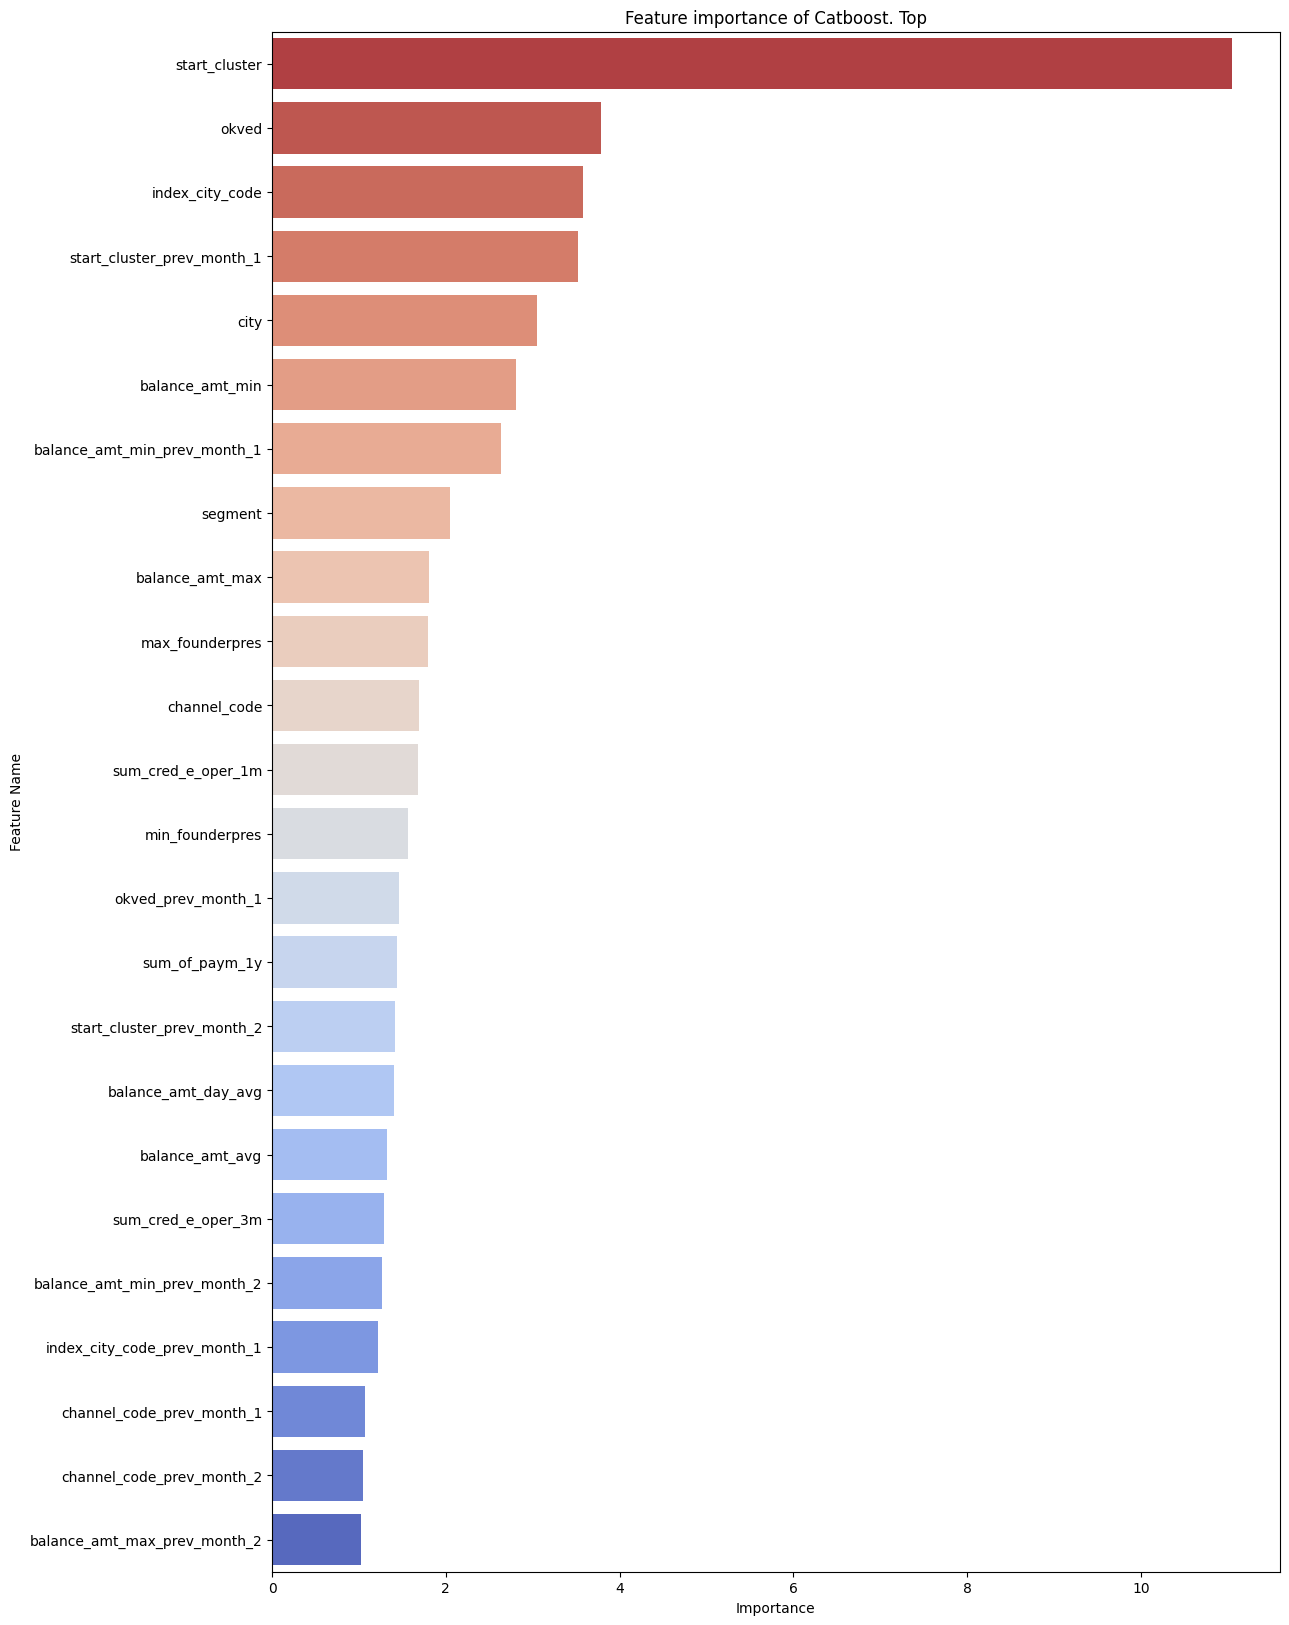

In [75]:
figure, ax = plt.subplots(figsize=(13, 20))
palette = sns.color_palette("coolwarm", len(very_important))
palette = np.array(palette[::-1] * (len(very_important) // len(palette) + 1))

sns.barplot(x=very_important['importance'], y=very_important['feature name'], ax=ax,
            palette=palette)
plt.title('Feature importance of Catboost. Top')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()

Базовая модель уже хорошо справляется с задачей по базовой метрике. Однако, чтобы увеличить её робастность и получить дополнительный рост в производительности, для итогового решения будем использовать ансамбль из 15 Catboost классификаторов, натренированных на фолдах кросс-валидации и валидированых на остальных данных. Практика показывает, что данных достаточно, чтобы это сделать.

In [78]:
catboost_params = {
    'iterations': 1500,
    'depth': 6,
    'loss_function': 'MultiClass',
    'task_type': 'GPU',  # Включаем GPU
    'random_seed': 42,
    'learning_rate': 0.05,
    'early_stopping_rounds': 15,
    'verbose': 100
}

# Создаем CatBoost classifier
model0 = cv(cv_dataset, params=catboost_params, seed=42, fold_count=15, return_models=True)

Training on fold [0/15]


0:	learn: 2.4240318	test: 2.4254650	best: 2.4254650 (0)	total: 81.7ms	remaining: 2m 2s
100:	learn: 0.8422310	test: 0.8553357	best: 0.8553357 (100)	total: 4.53s	remaining: 1m 2s
200:	learn: 0.8112314	test: 0.8309719	best: 0.8309719 (200)	total: 8.77s	remaining: 56.7s
300:	learn: 0.7964534	test: 0.8218219	best: 0.8218219 (300)	total: 13.1s	remaining: 52.2s
400:	learn: 0.7863849	test: 0.8171144	best: 0.8171144 (400)	total: 17.5s	remaining: 47.9s
500:	learn: 0.7784786	test: 0.8135062	best: 0.8135062 (500)	total: 21.5s	remaining: 42.9s
600:	learn: 0.7718887	test: 0.8112413	best: 0.8112413 (600)	total: 25.6s	remaining: 38.2s
700:	learn: 0.7653200	test: 0.8092305	best: 0.8092305 (700)	total: 29.6s	remaining: 33.8s
800:	learn: 0.7592910	test: 0.8077203	best: 0.8077203 (800)	total: 33.6s	remaining: 29.3s
900:	learn: 0.7538960	test: 0.8063538	best: 0.8063538 (900)	total: 37.6s	remaining: 25s
1000:	learn: 0.7483682	test: 0.8054375	best: 0.8054375 (1000)	total: 41.6s	remaining: 20.8s
1100:	learn: 

0:	learn: 2.4245963	test: 2.4243216	best: 2.4243216 (0)	total: 78.8ms	remaining: 1m 58s
100:	learn: 0.8419813	test: 0.8469501	best: 0.8469501 (100)	total: 4.61s	remaining: 1m 3s
200:	learn: 0.8100993	test: 0.8231322	best: 0.8231322 (200)	total: 8.91s	remaining: 57.6s
300:	learn: 0.7947905	test: 0.8153031	best: 0.8153031 (300)	total: 13.2s	remaining: 52.6s
400:	learn: 0.7846815	test: 0.8112064	best: 0.8112064 (400)	total: 17.5s	remaining: 47.9s
500:	learn: 0.7769025	test: 0.8086886	best: 0.8086886 (500)	total: 21.8s	remaining: 43.4s
600:	learn: 0.7705757	test: 0.8068749	best: 0.8068749 (600)	total: 25.8s	remaining: 38.6s
700:	learn: 0.7648314	test: 0.8055581	best: 0.8055542 (697)	total: 29.9s	remaining: 34s
800:	learn: 0.7589355	test: 0.8044617	best: 0.8044617 (800)	total: 33.9s	remaining: 29.6s
900:	learn: 0.7537520	test: 0.8035163	best: 0.8035163 (900)	total: 38s	remaining: 25.3s
1000:	learn: 0.7487158	test: 0.8029108	best: 0.8029047 (998)	total: 42.2s	remaining: 21s
1100:	learn: 0.74

0:	learn: 2.4244031	test: 2.4249581	best: 2.4249581 (0)	total: 86.1ms	remaining: 2m 9s
100:	learn: 0.8417372	test: 0.8540780	best: 0.8540780 (100)	total: 4.67s	remaining: 1m 4s
200:	learn: 0.8100746	test: 0.8297599	best: 0.8297599 (200)	total: 9.18s	remaining: 59.3s
300:	learn: 0.7943238	test: 0.8208490	best: 0.8208490 (300)	total: 13.5s	remaining: 53.8s
400:	learn: 0.7847006	test: 0.8166152	best: 0.8166152 (400)	total: 17.6s	remaining: 48.2s
500:	learn: 0.7769690	test: 0.8138379	best: 0.8138379 (500)	total: 21.8s	remaining: 43.5s
600:	learn: 0.7704261	test: 0.8120678	best: 0.8120678 (600)	total: 25.9s	remaining: 38.7s
700:	learn: 0.7642672	test: 0.8107100	best: 0.8107100 (700)	total: 29.8s	remaining: 34s
800:	learn: 0.7584354	test: 0.8094737	best: 0.8094737 (800)	total: 33.8s	remaining: 29.5s
900:	learn: 0.7531144	test: 0.8084489	best: 0.8084363 (897)	total: 37.8s	remaining: 25.1s
1000:	learn: 0.7478026	test: 0.8076827	best: 0.8076827 (1000)	total: 41.9s	remaining: 20.9s
bestTest = 0.

0:	learn: 2.4240414	test: 2.4254877	best: 2.4254877 (0)	total: 76.3ms	remaining: 1m 54s
100:	learn: 0.8418062	test: 0.8499800	best: 0.8499800 (100)	total: 4.76s	remaining: 1m 6s
200:	learn: 0.8105297	test: 0.8249148	best: 0.8249148 (200)	total: 9.26s	remaining: 59.8s
300:	learn: 0.7943436	test: 0.8156942	best: 0.8156942 (300)	total: 13.8s	remaining: 55s
400:	learn: 0.7844701	test: 0.8115654	best: 0.8115654 (400)	total: 18.1s	remaining: 49.7s
500:	learn: 0.7766069	test: 0.8088772	best: 0.8088772 (500)	total: 22.4s	remaining: 44.8s
600:	learn: 0.7697432	test: 0.8068456	best: 0.8068456 (600)	total: 26.8s	remaining: 40.1s
700:	learn: 0.7635046	test: 0.8053562	best: 0.8053550 (699)	total: 30.9s	remaining: 35.2s
800:	learn: 0.7579310	test: 0.8041365	best: 0.8041321 (799)	total: 35s	remaining: 30.5s
900:	learn: 0.7525384	test: 0.8033603	best: 0.8033603 (900)	total: 39.2s	remaining: 26.1s
1000:	learn: 0.7470963	test: 0.8026690	best: 0.8026690 (1000)	total: 43.5s	remaining: 21.7s
1100:	learn: 0

0:	learn: 2.4241290	test: 2.4252412	best: 2.4252412 (0)	total: 77.1ms	remaining: 1m 55s
100:	learn: 0.8410957	test: 0.8577968	best: 0.8577968 (100)	total: 4.55s	remaining: 1m 2s
200:	learn: 0.8105870	test: 0.8349937	best: 0.8349937 (200)	total: 8.89s	remaining: 57.5s
300:	learn: 0.7953093	test: 0.8265955	best: 0.8265955 (300)	total: 13.4s	remaining: 53.6s
400:	learn: 0.7849576	test: 0.8223771	best: 0.8223771 (400)	total: 17.8s	remaining: 48.9s
500:	learn: 0.7771847	test: 0.8199430	best: 0.8199430 (500)	total: 21.9s	remaining: 43.6s
600:	learn: 0.7705181	test: 0.8180066	best: 0.8179890 (599)	total: 25.9s	remaining: 38.7s
700:	learn: 0.7641699	test: 0.8163500	best: 0.8163500 (700)	total: 29.9s	remaining: 34.1s
800:	learn: 0.7585225	test: 0.8152436	best: 0.8152248 (798)	total: 33.9s	remaining: 29.6s
900:	learn: 0.7531266	test: 0.8142216	best: 0.8142176 (895)	total: 38s	remaining: 25.3s
1000:	learn: 0.7480307	test: 0.8132710	best: 0.8132708 (995)	total: 42s	remaining: 20.9s
1100:	learn: 0.

0:	learn: 2.4243423	test: 2.4243280	best: 2.4243280 (0)	total: 78.1ms	remaining: 1m 57s
100:	learn: 0.8422188	test: 0.8450251	best: 0.8450251 (100)	total: 4.65s	remaining: 1m 4s
200:	learn: 0.8110288	test: 0.8212303	best: 0.8212303 (200)	total: 9.19s	remaining: 59.4s
300:	learn: 0.7958031	test: 0.8129376	best: 0.8129376 (300)	total: 13.5s	remaining: 53.7s
400:	learn: 0.7860015	test: 0.8088928	best: 0.8088928 (400)	total: 17.7s	remaining: 48.6s
500:	learn: 0.7782916	test: 0.8060842	best: 0.8060842 (500)	total: 21.8s	remaining: 43.4s
600:	learn: 0.7715939	test: 0.8041606	best: 0.8041606 (600)	total: 26s	remaining: 38.9s
700:	learn: 0.7656203	test: 0.8026110	best: 0.8026110 (700)	total: 30.2s	remaining: 34.4s
800:	learn: 0.7594415	test: 0.8013340	best: 0.8013333 (799)	total: 34.3s	remaining: 30s
900:	learn: 0.7542185	test: 0.8002821	best: 0.8002821 (900)	total: 38.3s	remaining: 25.5s
1000:	learn: 0.7489349	test: 0.7996360	best: 0.7996200 (998)	total: 42.3s	remaining: 21.1s
1100:	learn: 0.

0:	learn: 2.4243552	test: 2.4239781	best: 2.4239781 (0)	total: 79.9ms	remaining: 1m 59s
100:	learn: 0.8417561	test: 0.8473454	best: 0.8473454 (100)	total: 4.75s	remaining: 1m 5s
200:	learn: 0.8109447	test: 0.8239870	best: 0.8239870 (200)	total: 9.2s	remaining: 59.4s
300:	learn: 0.7958983	test: 0.8152215	best: 0.8152215 (300)	total: 13.3s	remaining: 53.2s
400:	learn: 0.7859459	test: 0.8106348	best: 0.8106348 (400)	total: 17.4s	remaining: 47.8s
500:	learn: 0.7782718	test: 0.8078775	best: 0.8078775 (500)	total: 21.5s	remaining: 42.8s
600:	learn: 0.7715038	test: 0.8060984	best: 0.8060984 (600)	total: 25.4s	remaining: 38.1s
700:	learn: 0.7657574	test: 0.8049938	best: 0.8049938 (700)	total: 29.6s	remaining: 33.7s
800:	learn: 0.7601591	test: 0.8036796	best: 0.8036796 (800)	total: 33.8s	remaining: 29.5s
900:	learn: 0.7547708	test: 0.8026766	best: 0.8026766 (900)	total: 37.9s	remaining: 25.2s
1000:	learn: 0.7491892	test: 0.8011832	best: 0.8011832 (1000)	total: 42.2s	remaining: 21s
1100:	learn: 

0:	learn: 2.4240878	test: 2.4255475	best: 2.4255475 (0)	total: 79.4ms	remaining: 1m 59s
100:	learn: 0.8417062	test: 0.8501535	best: 0.8501535 (100)	total: 4.8s	remaining: 1m 6s
200:	learn: 0.8106823	test: 0.8260924	best: 0.8260924 (200)	total: 9.2s	remaining: 59.5s
300:	learn: 0.7954091	test: 0.8167106	best: 0.8167106 (300)	total: 13.4s	remaining: 53.3s
400:	learn: 0.7849495	test: 0.8118775	best: 0.8118775 (400)	total: 17.5s	remaining: 48s
500:	learn: 0.7769655	test: 0.8089569	best: 0.8089569 (500)	total: 21.6s	remaining: 43.1s
600:	learn: 0.7700385	test: 0.8071014	best: 0.8070952 (599)	total: 25.6s	remaining: 38.3s
700:	learn: 0.7638936	test: 0.8058655	best: 0.8058655 (700)	total: 29.7s	remaining: 33.8s
800:	learn: 0.7581310	test: 0.8048622	best: 0.8048622 (800)	total: 33.7s	remaining: 29.4s
900:	learn: 0.7527660	test: 0.8038182	best: 0.8038182 (900)	total: 37.9s	remaining: 25.2s
1000:	learn: 0.7474601	test: 0.8030106	best: 0.8030106 (1000)	total: 41.9s	remaining: 20.9s
1100:	learn: 0

0:	learn: 2.4244206	test: 2.4228404	best: 2.4228404 (0)	total: 78.9ms	remaining: 1m 58s
100:	learn: 0.8424236	test: 0.8366047	best: 0.8366047 (100)	total: 4.65s	remaining: 1m 4s
200:	learn: 0.8114965	test: 0.8126976	best: 0.8126976 (200)	total: 8.97s	remaining: 58s
300:	learn: 0.7962472	test: 0.8036003	best: 0.8036003 (300)	total: 13.2s	remaining: 52.4s
400:	learn: 0.7857428	test: 0.7991459	best: 0.7991459 (400)	total: 17.3s	remaining: 47.4s
500:	learn: 0.7780213	test: 0.7967489	best: 0.7967489 (500)	total: 21.6s	remaining: 43.1s
600:	learn: 0.7713861	test: 0.7952465	best: 0.7952260 (595)	total: 25.6s	remaining: 38.3s
700:	learn: 0.7653979	test: 0.7939637	best: 0.7939637 (700)	total: 29.8s	remaining: 33.9s
800:	learn: 0.7597118	test: 0.7931095	best: 0.7931095 (800)	total: 33.8s	remaining: 29.5s
900:	learn: 0.7542830	test: 0.7922598	best: 0.7922598 (900)	total: 37.9s	remaining: 25.2s
1000:	learn: 0.7494615	test: 0.7916355	best: 0.7916218 (997)	total: 41.9s	remaining: 20.9s
bestTest = 0.

0:	learn: 2.4240794	test: 2.4242143	best: 2.4242143 (0)	total: 73.6ms	remaining: 1m 50s
100:	learn: 0.8416929	test: 0.8440231	best: 0.8440231 (100)	total: 4.89s	remaining: 1m 7s
200:	learn: 0.8110377	test: 0.8208967	best: 0.8208967 (200)	total: 9.33s	remaining: 1m
300:	learn: 0.7953872	test: 0.8115683	best: 0.8115683 (300)	total: 13.7s	remaining: 54.7s
400:	learn: 0.7847274	test: 0.8063895	best: 0.8063895 (400)	total: 17.9s	remaining: 49.1s
500:	learn: 0.7774744	test: 0.8037657	best: 0.8037657 (500)	total: 21.9s	remaining: 43.7s
600:	learn: 0.7704349	test: 0.8019885	best: 0.8019885 (600)	total: 26s	remaining: 38.9s
700:	learn: 0.7644630	test: 0.8007511	best: 0.8007511 (700)	total: 30s	remaining: 34.2s
800:	learn: 0.7589445	test: 0.7997747	best: 0.7997747 (800)	total: 34.2s	remaining: 29.8s
900:	learn: 0.7538881	test: 0.7987530	best: 0.7987426 (899)	total: 38.3s	remaining: 25.4s
bestTest = 0.7982371479
bestIteration = 967
Training on fold [10/15]


0:	learn: 2.4243099	test: 2.4237773	best: 2.4237773 (0)	total: 78.5ms	remaining: 1m 57s
100:	learn: 0.8420136	test: 0.8447096	best: 0.8447096 (100)	total: 4.73s	remaining: 1m 5s
200:	learn: 0.8108423	test: 0.8190569	best: 0.8190569 (200)	total: 9.29s	remaining: 1m
300:	learn: 0.7958348	test: 0.8097960	best: 0.8097960 (300)	total: 13.7s	remaining: 54.6s
400:	learn: 0.7858342	test: 0.8051465	best: 0.8051465 (400)	total: 18.1s	remaining: 49.5s
500:	learn: 0.7782880	test: 0.8021782	best: 0.8021782 (500)	total: 22.2s	remaining: 44.2s
600:	learn: 0.7707131	test: 0.7998276	best: 0.7998276 (600)	total: 26.6s	remaining: 39.7s
700:	learn: 0.7647440	test: 0.7982038	best: 0.7982038 (700)	total: 30.8s	remaining: 35.1s
800:	learn: 0.7589503	test: 0.7969276	best: 0.7969276 (800)	total: 34.8s	remaining: 30.4s
900:	learn: 0.7532772	test: 0.7958075	best: 0.7958075 (900)	total: 39s	remaining: 25.9s
1000:	learn: 0.7481632	test: 0.7949635	best: 0.7949635 (1000)	total: 43.3s	remaining: 21.6s
1100:	learn: 0.

0:	learn: 2.4242945	test: 2.4242471	best: 2.4242471 (0)	total: 79.3ms	remaining: 1m 58s
100:	learn: 0.8412334	test: 0.8544605	best: 0.8544605 (100)	total: 4.92s	remaining: 1m 8s
200:	learn: 0.8101726	test: 0.8311842	best: 0.8311842 (200)	total: 9.45s	remaining: 1m 1s
300:	learn: 0.7952112	test: 0.8227555	best: 0.8227555 (300)	total: 13.9s	remaining: 55.4s
400:	learn: 0.7848135	test: 0.8187907	best: 0.8187874 (399)	total: 18.1s	remaining: 49.7s
500:	learn: 0.7773390	test: 0.8163418	best: 0.8163418 (500)	total: 22.3s	remaining: 44.5s
600:	learn: 0.7706783	test: 0.8146353	best: 0.8146353 (600)	total: 26.4s	remaining: 39.5s
700:	learn: 0.7646382	test: 0.8130451	best: 0.8130451 (700)	total: 30.4s	remaining: 34.6s
800:	learn: 0.7588489	test: 0.8118642	best: 0.8118642 (800)	total: 34.7s	remaining: 30.3s
900:	learn: 0.7533379	test: 0.8109540	best: 0.8109452 (894)	total: 38.9s	remaining: 25.9s
1000:	learn: 0.7478393	test: 0.8102934	best: 0.8102934 (1000)	total: 43.2s	remaining: 21.5s
bestTest =

0:	learn: 2.4245556	test: 2.4213547	best: 2.4213547 (0)	total: 79.3ms	remaining: 1m 58s
100:	learn: 0.8419953	test: 0.8431339	best: 0.8431339 (100)	total: 4.79s	remaining: 1m 6s
200:	learn: 0.8111097	test: 0.8215387	best: 0.8215387 (200)	total: 9.15s	remaining: 59.2s
300:	learn: 0.7960926	test: 0.8141629	best: 0.8141629 (300)	total: 13.4s	remaining: 53.4s
400:	learn: 0.7854663	test: 0.8105102	best: 0.8105102 (400)	total: 17.9s	remaining: 48.9s
500:	learn: 0.7774323	test: 0.8082681	best: 0.8082681 (500)	total: 22s	remaining: 43.8s
600:	learn: 0.7706520	test: 0.8068028	best: 0.8068020 (599)	total: 26.1s	remaining: 39.1s
700:	learn: 0.7644641	test: 0.8055436	best: 0.8055436 (700)	total: 30.2s	remaining: 34.4s
bestTest = 0.8048705459
bestIteration = 756
Training on fold [13/15]


0:	learn: 2.4245453	test: 2.4228860	best: 2.4228860 (0)	total: 80.4ms	remaining: 2m
100:	learn: 0.8425089	test: 0.8350776	best: 0.8350776 (100)	total: 4.71s	remaining: 1m 5s
200:	learn: 0.8113802	test: 0.8117899	best: 0.8117899 (200)	total: 9.07s	remaining: 58.6s
300:	learn: 0.7963192	test: 0.8036359	best: 0.8036359 (300)	total: 13.5s	remaining: 53.8s
400:	learn: 0.7852726	test: 0.7987233	best: 0.7987194 (399)	total: 17.8s	remaining: 48.9s
500:	learn: 0.7776111	test: 0.7959428	best: 0.7959428 (500)	total: 22.1s	remaining: 44s
600:	learn: 0.7704730	test: 0.7939896	best: 0.7939896 (600)	total: 26.2s	remaining: 39.3s
700:	learn: 0.7646229	test: 0.7926637	best: 0.7926637 (700)	total: 30.4s	remaining: 34.7s
800:	learn: 0.7588082	test: 0.7916989	best: 0.7916989 (799)	total: 34.6s	remaining: 30.2s
900:	learn: 0.7532965	test: 0.7908874	best: 0.7908780 (894)	total: 38.7s	remaining: 25.7s
1000:	learn: 0.7483857	test: 0.7902749	best: 0.7902722 (999)	total: 42.6s	remaining: 21.2s
bestTest = 0.7899

0:	learn: 2.4238036	test: 2.4253140	best: 2.4253140 (0)	total: 76ms	remaining: 1m 53s
100:	learn: 0.8413584	test: 0.8504550	best: 0.8504550 (100)	total: 4.74s	remaining: 1m 5s
200:	learn: 0.8109524	test: 0.8259797	best: 0.8259797 (200)	total: 9.01s	remaining: 58.2s
300:	learn: 0.7963101	test: 0.8176203	best: 0.8176203 (300)	total: 13.3s	remaining: 53s
400:	learn: 0.7854779	test: 0.8126667	best: 0.8126667 (400)	total: 17.4s	remaining: 47.8s
500:	learn: 0.7771447	test: 0.8093841	best: 0.8093841 (500)	total: 21.6s	remaining: 43s
600:	learn: 0.7702270	test: 0.8076904	best: 0.8076881 (599)	total: 25.7s	remaining: 38.5s
700:	learn: 0.7639914	test: 0.8059687	best: 0.8059687 (700)	total: 30s	remaining: 34.1s
800:	learn: 0.7581095	test: 0.8048439	best: 0.8048439 (800)	total: 34.2s	remaining: 29.8s
900:	learn: 0.7525472	test: 0.8037818	best: 0.8037770 (895)	total: 38.5s	remaining: 25.6s
1000:	learn: 0.7475424	test: 0.8030711	best: 0.8030675 (998)	total: 42.6s	remaining: 21.2s
1100:	learn: 0.7427

In [79]:
for i in range(len(model0[1])):
    model0[1][i].save_model(f'models/model_{i}', format='cbm')

In [18]:
models = [CatBoostClassifier().load_model(f'models/model_{i}') for i in range(15)] # можно не заменять на предыдущем шаге файлы, а загрузить их из памяти

In [81]:
res = np.mean([models[i].predict_proba(X) for i in range(len(models))], axis=0)
res

array([[2.88469357e-01, 5.93042699e-04, 5.16422794e-03, ...,
        2.45095237e-04, 3.86898979e-02, 7.27128028e-06],
       [7.85824564e-01, 8.42316902e-04, 5.12252412e-03, ...,
        1.57535632e-03, 3.85112346e-02, 8.78396343e-06],
       [3.71991057e-03, 1.27884393e-02, 9.17089810e-03, ...,
        4.64230678e-04, 9.50032047e-01, 1.83024006e-05],
       ...,
       [6.98290228e-01, 2.10072602e-03, 5.87364026e-03, ...,
        3.58996334e-02, 4.60630519e-02, 1.63976934e-05],
       [2.87899949e-02, 5.38351568e-01, 5.48898896e-04, ...,
        6.85347904e-04, 3.50780510e-01, 1.72680620e-05],
       [4.38249430e-03, 6.67741314e-01, 1.07657762e-03, ...,
        4.21843368e-04, 3.15207879e-01, 2.33194063e-04]])

In [82]:
weighted_roc_auc(y, res, models[0].classes_, weights_dict)

0.9537619584967261

## **Прогноз на тестовой выборке**

In [83]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year"
]

**Фильтрация данных и объединение таблиц:**
   - Из тестовой выборки выделяются записи за последний месяц 'month_6' в last_month_df.
   - Создаются DataFrame для данных за предыдущие два месяца 'month_5' и 'month_4' в prev_month_5_df и prev_month_4_df.
   - Столбцы с категориальными признаками приводятся к типу 'category'.
   - Столбцы переименовываются, чтобы избежать конфликтов имен.
   - Данные за предыдущие месяцы объединяются в prev_months_combined.
   - Данные за последний месяц объединяются с данными за предыдущие месяцы в final_df.

In [84]:
# Фильтрация данных, оставляем только записи за последний месяц
last_month_df = test_df[test_df['date'] == 'month_6']

# Создание DataFrame для данных за предыдущие два месяца
prev_month_5_df = test_df[test_df['date'] == 'month_5'].set_index('id')
prev_month_4_df = test_df[test_df['date'] == 'month_4'].set_index('id')
prev_month_5_df[cat_cols] = prev_month_5_df[cat_cols].astype("category")
prev_month_4_df[cat_cols] = prev_month_4_df[cat_cols].astype("category")

# Переименование столбцов, чтобы избежать конфликтов имен
prev_month_5_df.columns = [f'{col}_prev_month_2' for col in prev_month_5_df.columns]
prev_month_4_df.columns = [f'{col}_prev_month_1' for col in prev_month_4_df.columns]

# Объединение данных за предыдущие месяцы
prev_months_combined = prev_month_5_df.join(prev_month_4_df, how='outer')

# Объединение данных за последний месяц с данными за предыдущие месяцы
final_df = last_month_df.set_index('id').join(prev_months_combined, how='left')

# Вывод результата
final_df


,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,...,sum_cred_g_oper_3m_prev_month_1,cnt_cred_g_oper_3m_prev_month_1,cnt_days_cred_g_oper_3m_prev_month_1,sum_deb_h_oper_3m_prev_month_1,cnt_deb_h_oper_3m_prev_month_1,cnt_days_deb_h_oper_3m_prev_month_1,sum_cred_h_oper_3m_prev_month_1,cnt_cred_h_oper_3m_prev_month_1,cnt_days_cred_h_oper_3m_prev_month_1,start_cluster_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,-1.533705,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
200001,month_6,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,0.092087,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200002,month_6,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,-1.069193,...,0.510730,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{other}
200003,month_6,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,None,-0.256297,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200004,month_6,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,None,None,None,0.672727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,month_6,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,1.601751,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
299996,month_6,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,-0.604681,...,-0.028584,0.944497,0.384773,-0.165057,0.547606,0.429909,-0.198087,0.252079,0.418496,{α}
299997,month_6,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,0.440471,...,-0.028584,0.944497,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α}


In [85]:
test_df.pivot(index="id", columns="date", values="start_cluster").head(3)

date,month_4,month_5,month_6
id,,,
200000,{α},{α},None
200001,{α},{α},None
200002,{other},{other},None


**Заполнение стартового кластера:**

Для того, чтобы сделать прогноз на тестовой выборке, нужно заполнить стартовый кластер. </br>


Проверим, насаколько часто стартовый кластер меняется за один месяц

In [86]:
sum(train_df[train_df['date'] == 'month_1']['start_cluster'].values != train_df[train_df['date'] == 'month_2']['start_cluster'].values) / len(train_df[train_df['date']=='month_2'])

0.09133

В обучающей выборке стартовый кластер изменяется между первым и вторым месяцами в 9% случаев

In [990]:
sum(train_df[train_df['date'] == 'month_2']['start_cluster'].values != train_df[train_df['date'] == 'month_3']['start_cluster'].values) / len(train_df[train_df['date']=='month_3'])

0.11851

Между 2 и 3 месяцами в 11% случаев

In [87]:
len(test_df[test_df['date'] == 'month_4']), len(test_df[test_df['date'] == 'month_5'])

(90120, 100000)

В тестовой выборке 90120 записей о 4 месяце и 100000 записей о 5 месяце 

In [88]:
t_month_4 = test_df[test_df['date']=='month_4'].set_index('id').index

In [89]:
t_month_5 = test_df[test_df['date'] == 'month_5'].set_index('id').index

In [90]:
index = t_month_4.intersection(t_month_5)

In [91]:
# Данные о клиентах, имеющих записи и за 4 и за 5 месяца
t = test_df.set_index('id').loc[index]

In [92]:
sum(t[t['date'] == 'month_4']['start_cluster'].values != t[t['date'] == 'month_5']['start_cluster'].values) / len(test_df[test_df['date']=='month_5'])

0.06698

Получается, 6% клиентов поменяли свой стартовый кластер с 4 на 5 месяц

На основании достаточно низкого процента клиентов, меняющих свой кластер от месяца к месяцу, было принято решение заменить значение start_cluster в шестом месяце значением start_cluster за пятый месяц.

Также были предприняты попытки построить модель, которая предсказывала бы переход клиента в другой начальный кластер в следующем месяце. Но данная модель показала худший результат по сравнению с простой заменой занчения start cluster на значение из предыдущего месяца. Значение ошибки варьировалось от 18% до 20%.

In [93]:
filtered_rows = test_df[test_df['date'] == 'month_5']
start_cluster_column = filtered_rows['start_cluster']

# Вывод результатов
print(start_cluster_column)

1             {α}
4             {α}
7         {other}
10            {α}
12             {}
           ...   
290107        {α}
290110        {α}
290113        {α}
290115         {}
290118        {α}
Name: start_cluster, Length: 100000, dtype: object


In [20]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")

In [95]:
sample_submission_df.shape

(100000, 18)

In [96]:
sample_submission_df.head()

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,200001,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,200002,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,200003,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,200004,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


Для тестовой выборки будем использовать только последний месяц

### **Подготовка данных для прогноза:**
   - стартовый кластер заполняется значением за 5 месяц
   - Удаляются незначимые признаки
   - Пропуски в категориальных столбцах заполняются значением "None".

In [97]:
final_df = final_df.drop(["date",'date_prev_month_1','date_prev_month_2'], axis=1)
final_df.drop("start_cluster", axis=1)
final_df["start_cluster"] = start_cluster_column.values
final_df["start_cluster"] = final_df["start_cluster"].astype("category")
final_df["start_cluster"]

id
200000        {α}
200001        {α}
200002    {other}
200003        {α}
200004         {}
           ...   
299995        {α}
299996        {α}
299997        {α}
299998         {}
299999        {α}
Name: start_cluster, Length: 100000, dtype: category
Categories (17, object): ['{other}', '{}', '{α, β}', '{α, γ}', ..., '{α, π}', '{α, ψ}', '{α}', '{λ}']

In [98]:
final_df

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,sum_cred_g_oper_3m_prev_month_1,cnt_cred_g_oper_3m_prev_month_1,cnt_days_cred_g_oper_3m_prev_month_1,sum_deb_h_oper_3m_prev_month_1,cnt_deb_h_oper_3m_prev_month_1,cnt_days_deb_h_oper_3m_prev_month_1,sum_cred_h_oper_3m_prev_month_1,cnt_cred_h_oper_3m_prev_month_1,cnt_days_cred_h_oper_3m_prev_month_1,start_cluster_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
200000,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,-1.533705,-1.683741,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
200001,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,0.092087,1.220030,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200002,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,city_type_0,index_city_code_78,-1.069193,-1.528873,...,0.510730,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{other}
200003,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,city_type_0,None,-0.256297,-1.257854,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200004,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,None,None,None,0.672727,1.413615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,city_type_0,index_city_code_29,1.601751,-0.638383,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
299996,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,city_type_0,index_city_code_66,-0.604681,0.987728,...,-0.028584,0.944497,0.384773,-0.165057,0.547606,0.429909,-0.198087,0.252079,0.418496,{α}
299997,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,city_type_0,index_city_code_103,0.440471,1.336181,...,-0.028584,0.944497,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α}


In [99]:
# Функция для добавления новых слов в названия столбцов
def add_word(cols, suffix):
    return [col + suffix for col in cols]

# Добавление"_prev_month_2" и "_prev_month_1"
new_cat_cols = add_word(cat_cols, "_prev_month_2") + add_word(cat_cols, "_prev_month_1")
cat_cols += new_cat_cols

In [100]:
clusters = ['start_cluster_prev_month_1','start_cluster_prev_month_2']
final_df[clusters] = final_df[clusters].astype('category')
final_df['start_cluster_prev_month_1'] = final_df['start_cluster_prev_month_1'].cat.add_categories(["None"])
final_df['start_cluster_prev_month_2'] = final_df['start_cluster_prev_month_2'].cat.add_categories(["None"])

In [101]:
final_df[new_cat_cols] 

,channel_code_prev_month_2,city_prev_month_2,city_type_prev_month_2,okved_prev_month_2,segment_prev_month_2,start_cluster_prev_month_2,index_city_code_prev_month_2,ogrn_month_prev_month_2,ogrn_year_prev_month_2,channel_code_prev_month_1,city_prev_month_1,city_type_prev_month_1,okved_prev_month_1,segment_prev_month_1,start_cluster_prev_month_1,index_city_code_prev_month_1,ogrn_month_prev_month_1,ogrn_year_prev_month_1
id,,,,,,,,,,,,,,,,,,
200000,channel_code_12,city_14,city_type_0,okved_0,segment_3,{α},None,ogrn_month_8,ogrn_year_11,channel_code_12,city_14,city_type_0,okved_0,segment_3,{α},None,ogrn_month_8,ogrn_year_11
200001,channel_code_9,city_76,city_type_0,okved_6,segment_3,{α},None,ogrn_month_10,ogrn_year_11,channel_code_9,city_76,city_type_0,okved_6,segment_3,{α},None,ogrn_month_10,ogrn_year_11
200002,channel_code_12,city_14,city_type_0,okved_63,segment_3,{other},index_city_code_78,ogrn_month_6,ogrn_year_11,channel_code_12,city_14,city_type_0,okved_63,segment_3,{other},index_city_code_78,ogrn_month_6,ogrn_year_11
200003,channel_code_7,city_31,city_type_0,okved_5,segment_3,{α},None,ogrn_month_9,ogrn_year_4,channel_code_7,city_31,city_type_0,okved_5,segment_3,{α},None,ogrn_month_9,ogrn_year_4
200004,None,None,None,None,None,{},None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,channel_code_14,city_22,city_type_0,okved_4,segment_0,{α},index_city_code_29,ogrn_month_6,ogrn_year_20,channel_code_14,city_22,city_type_0,okved_4,segment_0,{α},index_city_code_29,ogrn_month_6,ogrn_year_20
299996,channel_code_1,city_96,city_type_0,okved_4,segment_1,{α},index_city_code_66,ogrn_month_10,ogrn_year_15,channel_code_1,city_96,city_type_0,okved_4,segment_1,{α},index_city_code_66,ogrn_month_10,ogrn_year_15
299997,channel_code_17,city_85,city_type_0,okved_46,segment_3,{α},index_city_code_103,ogrn_month_7,ogrn_year_4,channel_code_17,city_85,city_type_0,okved_46,segment_3,{α},index_city_code_103,ogrn_month_7,ogrn_year_4


In [102]:
final_df = final_df.drop(zero_importance, axis=1)
cat_cols = list(set(cat_cols).difference(cat_cols_to_remove))

In [103]:
final_df[cat_cols]

,ogrn_month_prev_month_2,ogrn_month_prev_month_1,ogrn_year_prev_month_1,index_city_code_prev_month_1,city,index_city_code_prev_month_2,segment_prev_month_2,okved_prev_month_1,start_cluster_prev_month_1,ogrn_year_prev_month_2,...,okved_prev_month_2,segment_prev_month_1,segment,start_cluster_prev_month_2,ogrn_year,index_city_code,channel_code,ogrn_month,start_cluster,city_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
200000,ogrn_month_8,ogrn_month_8,ogrn_year_11,None,city_14,None,segment_3,okved_0,{α},ogrn_year_11,...,okved_0,segment_3,segment_3,{α},ogrn_year_11,None,channel_code_12,ogrn_month_8,{α},city_14
200001,ogrn_month_10,ogrn_month_10,ogrn_year_11,None,city_76,None,segment_3,okved_6,{α},ogrn_year_11,...,okved_6,segment_3,segment_3,{α},ogrn_year_11,None,channel_code_9,ogrn_month_10,{α},city_76
200002,ogrn_month_6,ogrn_month_6,ogrn_year_11,index_city_code_78,city_14,index_city_code_78,segment_3,okved_63,{other},ogrn_year_11,...,okved_63,segment_3,segment_3,{other},ogrn_year_11,index_city_code_78,channel_code_12,ogrn_month_6,{other},city_14
200003,ogrn_month_9,ogrn_month_9,ogrn_year_4,None,city_31,None,segment_3,okved_5,{α},ogrn_year_4,...,okved_5,segment_3,segment_3,{α},ogrn_year_4,None,channel_code_7,ogrn_month_9,{α},city_31
200004,None,NaN,NaN,NaN,None,None,None,NaN,NaN,None,...,None,NaN,segment_3,{},ogrn_year_12,None,channel_code_7,ogrn_month_2,{},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,ogrn_month_6,ogrn_month_6,ogrn_year_20,index_city_code_29,city_22,index_city_code_29,segment_0,okved_4,{α},ogrn_year_20,...,okved_4,segment_0,segment_0,{α},ogrn_year_20,index_city_code_29,channel_code_14,ogrn_month_6,{α},city_22
299996,ogrn_month_10,ogrn_month_10,ogrn_year_15,index_city_code_66,city_96,index_city_code_66,segment_1,okved_4,{α},ogrn_year_15,...,okved_4,segment_1,segment_1,{α},ogrn_year_15,index_city_code_66,channel_code_1,ogrn_month_10,{α},city_96
299997,ogrn_month_7,ogrn_month_7,ogrn_year_4,index_city_code_103,city_85,index_city_code_103,segment_3,okved_46,{α},ogrn_year_4,...,okved_46,segment_3,segment_3,{α},ogrn_year_4,index_city_code_103,channel_code_17,ogrn_month_7,{α},city_85


In [104]:
final_df[cat_cols] = final_df[cat_cols].fillna("None",axis=1)

In [105]:
final_df

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,...,sum_cred_g_oper_3m_prev_month_1,cnt_cred_g_oper_3m_prev_month_1,cnt_days_cred_g_oper_3m_prev_month_1,sum_deb_h_oper_3m_prev_month_1,cnt_deb_h_oper_3m_prev_month_1,cnt_days_deb_h_oper_3m_prev_month_1,sum_cred_h_oper_3m_prev_month_1,cnt_cred_h_oper_3m_prev_month_1,cnt_days_cred_h_oper_3m_prev_month_1,start_cluster_prev_month_1
id,,,,,,,,,,,,,,,,,,,,,
200000,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,None,-1.533705,-1.683741,ogrn_month_8,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
200001,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,None,0.092087,1.220030,ogrn_month_10,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200002,-0.048015,0.448252,-0.125995,-0.047215,channel_code_12,city_14,index_city_code_78,-1.069193,-1.528873,ogrn_month_6,...,0.510730,0.950774,0.545693,0.715525,0.554913,0.718798,0.445811,0.254968,0.495419,{other}
200003,-0.156579,-0.204813,-0.125501,-0.156115,channel_code_7,city_31,None,-0.256297,-1.257854,ogrn_month_9,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
200004,-0.153379,-0.201932,-0.125995,-0.154155,channel_code_7,None,None,0.672727,1.413615,ogrn_month_2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,-0.153707,-0.202806,-0.125498,-0.153234,channel_code_14,city_22,index_city_code_29,1.601751,-0.638383,ogrn_month_6,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
299996,-0.154929,-0.197878,-0.125873,-0.154459,channel_code_1,city_96,index_city_code_66,-0.604681,0.987728,ogrn_month_10,...,-0.028584,0.944497,0.384773,-0.165057,0.547606,0.429909,-0.198087,0.252079,0.418496,{α}
299997,-0.105294,-0.141429,-0.104590,-0.104671,channel_code_17,city_85,index_city_code_103,0.440471,1.336181,ogrn_month_7,...,-0.028584,0.944497,0.384773,0.048962,0.551331,0.652131,0.016130,0.256412,0.550364,{α}


### **Прогноз с помощью модели:**


In [106]:
test_pred_proba = np.mean([models[i].predict_proba(final_df) for i in range(len(models))], axis=0)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=models[0].classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [107]:
test_pred_proba_df.shape

(100000, 17)

In [108]:
test_pred_proba_df.head(2)

,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,0.011671,0.020481,0.016716,0.019380,0.007023,0.000279,0.004400,0.000520,0.013161,0.004418,0.025705,0.000793,0.001794,0.000021,0.003047,0.870575,0.000017
1,0.006957,0.550449,0.000463,0.001796,0.000491,0.000164,0.000383,0.000027,0.001427,0.007588,0.001657,0.000304,0.000752,0.000003,0.000491,0.426966,0.000082


### **Создание файла с прогнозом:**

In [109]:
sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("submission_final.csv", index=False)

In [110]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.011671,0.020481,0.016716,0.019380,0.007023,0.000279,0.004400,0.000520,0.013161,0.004418,0.025705,0.000793,0.001794,0.000021,0.003047,0.870575,0.000017
1,200001,0.006957,0.550449,0.000463,0.001796,0.000491,0.000164,0.000383,0.000027,0.001427,0.007588,0.001657,0.000304,0.000752,0.000003,0.000491,0.426966,0.000082
2,200002,0.566372,0.004544,0.005482,0.108141,0.015956,0.002767,0.006677,0.026688,0.044282,0.009152,0.016803,0.010060,0.002771,0.000036,0.064068,0.116139,0.000060
3,200003,0.021469,0.643179,0.000479,0.000841,0.000281,0.000514,0.000410,0.000048,0.000894,0.015984,0.002916,0.000052,0.000864,0.000006,0.000316,0.311734,0.000014
4,200004,0.258302,0.087885,0.011248,0.013163,0.005627,0.011120,0.002528,0.000392,0.015417,0.131264,0.006883,0.000848,0.038164,0.000019,0.002633,0.414423,0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.011305,0.263583,0.001975,0.003656,0.001408,0.000025,0.000401,0.000012,0.000771,0.000604,0.000981,0.000298,0.000128,0.000045,0.000596,0.714115,0.000096
99996,299996,0.022442,0.047292,0.014940,0.037672,0.008978,0.000155,0.000621,0.000070,0.008990,0.005053,0.008828,0.003608,0.001782,0.000023,0.003099,0.835820,0.000628
99997,299997,0.029662,0.031572,0.031380,0.062219,0.014698,0.000093,0.001237,0.000378,0.012357,0.003862,0.008879,0.001179,0.002182,0.000046,0.018771,0.781467,0.000018
99998,299998,0.174293,0.116569,0.016772,0.032463,0.009722,0.001194,0.003877,0.002414,0.035109,0.018175,0.011857,0.011217,0.005307,0.000055,0.015824,0.543240,0.001912
